### Import Libraries

In [18]:
import torch
from torch import nn
import torch.optim as optim
import matplotlib.pyplot as plt
print(torch.__version__)

2.2.0


In [4]:
what_were_covering = {
    1: 'data (prepare and load)',
    2: 'build model',
    3: 'making predictions and evaluating a model (inference)',
    4: 'saving and loading a model',
    5: 'putting it all together'
}

### 1. Data (preparing and loading)

In [5]:
# Create "known" parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start=start, end=end, step=step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

#### Split data into training and test sets

In [8]:
# Create train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [9]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    plt.figure(figsize=(10,7))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c = 'b', s = 4, label = 'Training data')
    # Plot test data in green
    plt.scatter(test_data, test_labels, c = 'g', s = 4, label = 'Testing data')

    if predictions is not None:
        # Plot predictions in red
        plt.scatter(test_data, predictions, c = 'r', s = 4, label = 'Predictions')
    
    plt.legend(prop = {'size': 14})

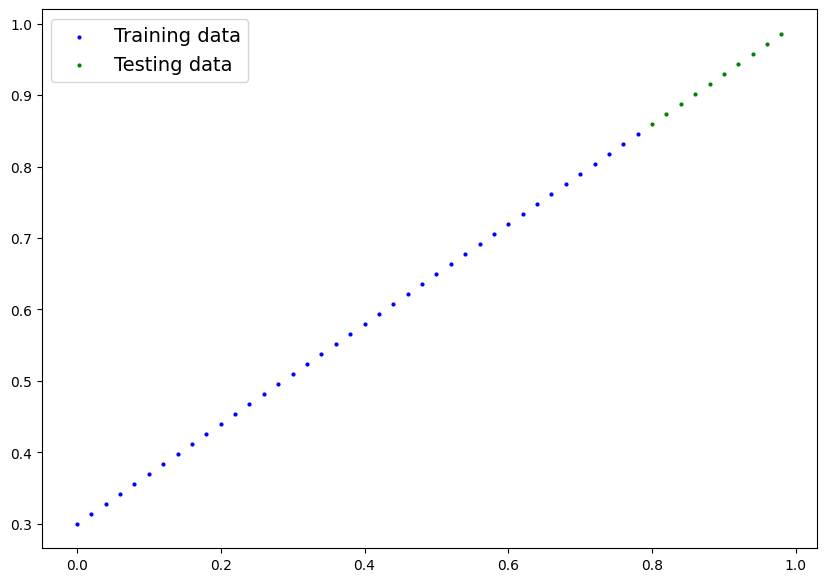

In [10]:
plot_predictions()

### 2. Build model

In [13]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
    def forward(self, x):
        return self.weights * x + self.bias

<b>nn.Parameter:</b> store tensors that can be used within the nn.Module\
<b>required_grad:</b> used for updating model params via gradient descent\
<b>torch.optim:</b> contains all optimization algos (tells model how to best improve gradient descent and in turn reduces loss)

#### Checking contents of a PyTorch model

In [29]:
# Set manual seed 
torch.manual_seed(42)

# Create instance of model
model_0 = LinearRegressionModel()

# Check model params
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [30]:
# List named params
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

#### Making predictions using torch.inference_mode()

In [31]:
# Make predictions
with torch.inference_mode():
    y_preds = model_0(X_test)

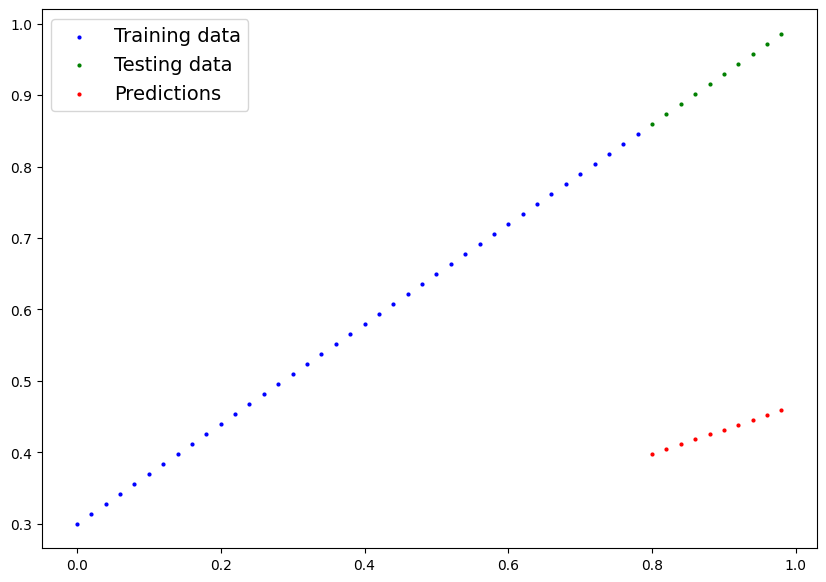

In [32]:
# Check predictions
plot_predictions(predictions=y_preds)

BAD!!!

### 3. Train model

#### Creating a loss function and optimizer in PyTorch

SGD and Adam are generally good.\
MAE (Mean Absolute Error) is good for regression, and\
BCELoss (Binary Cross Entropy Loss) is good for classification.

In [33]:
# Create a loss function
loss_fn = nn.L1Loss()
# Create the optimizer
optimizer = optim.SGD(params=model_0.parameters(), lr=0.01)

#### Creating an Optimization loop in PyTorch

In [34]:
torch.manual_seed(42)

epochs = 100

train_losses = []
test_losses = []
epoch_counts = []

for epoch in range(epochs):
    # Training
    model_0.train()
    y_pred = model_0(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_0.eval()
    with torch.inference_mode():
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_counts.append(epoch)
            train_losses.append(loss.detach().numpy())
            test_losses.append(test_loss.detach().numpy())
            print(f'Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}')

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788740023970604 | MAE Test Loss: 0.06473556160926819


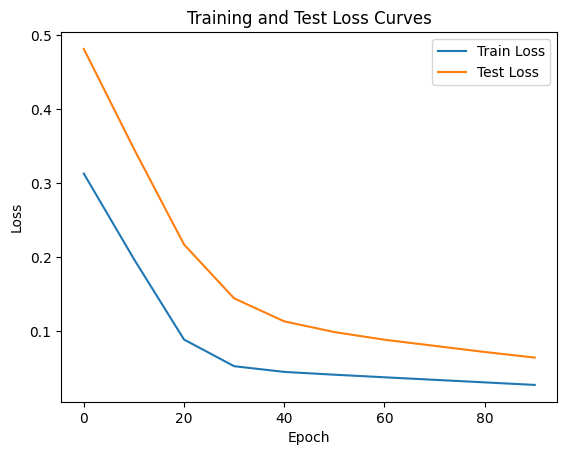

In [35]:
# Plot loss curve
plt.plot(epoch_counts, train_losses, label = 'Train Loss')
plt.plot(epoch_counts, test_losses, label = 'Test Loss')
plt.title('Training and Test Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [36]:
# Find our model's learned parameters
print(f'Model learnt the following params:\n{model_0.state_dict()}')
print(f'And original values were:\n{weight}\n{bias}')

Model learnt the following params:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])
And original values were:
0.7
0.3


### 4. Making predictions with a trained PyTorch model (inference)

In [37]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

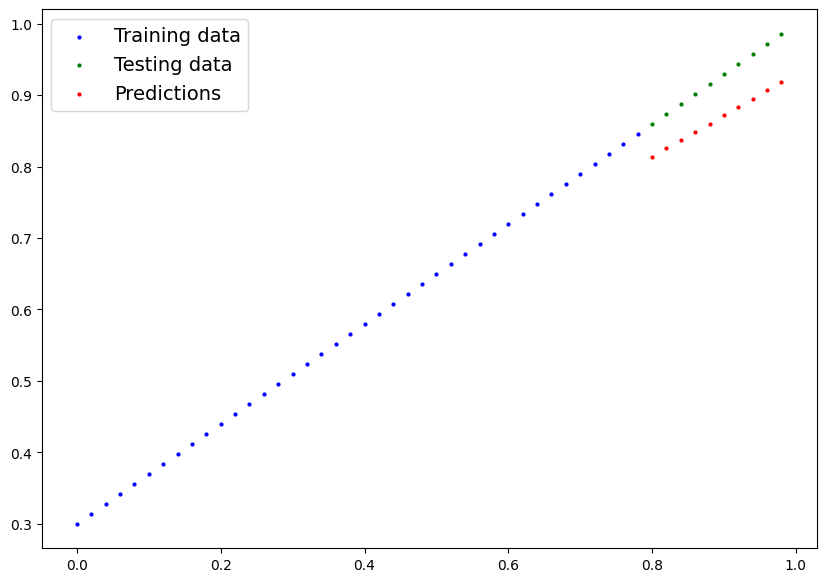

In [38]:
plot_predictions(predictions=y_preds)

### 5. Saving and Loading a PyTorch model

#### Saving a model

In [39]:
from pathlib import Path

model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)
model_name = '01_pytorch_workflow_model_0.pth'
model_save_path = model_path / model_name
print(f'Saving model to: {model_save_path}')
torch.save(obj=model_0.state_dict(), f=model_save_path)

Saving model to: models/01_pytorch_workflow_model_0.pth


#### Loading a saved model

In [40]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=model_save_path))

<All keys matched successfully>

In [41]:
# Test if they match
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### 6. Putting it all together

#### Data

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [44]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim = 1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [45]:
# Splt
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

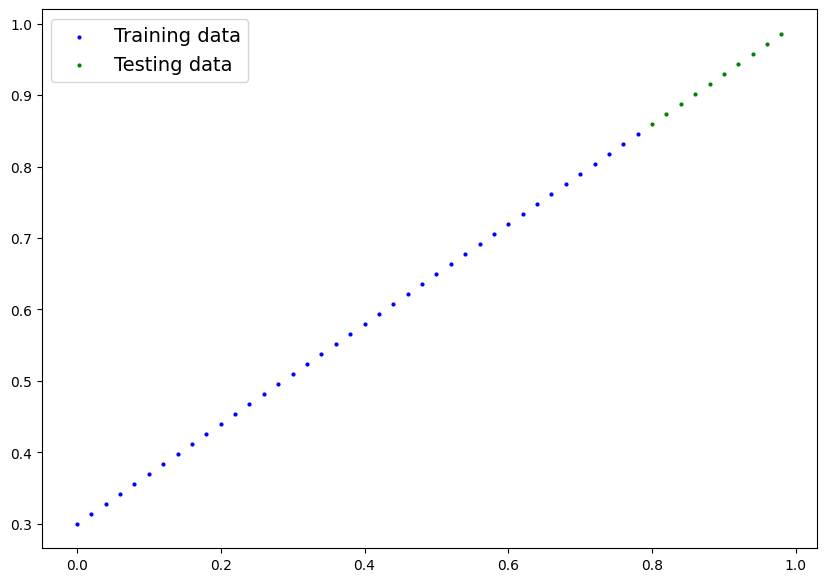

In [46]:
plot_predictions(X_train, y_train, X_test, y_test)

In [47]:
# Define Model architecture
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)
    def forward(self, x):
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [48]:
# Putting model on device
next(model_1.parameters()).device

device(type='cpu')

In [49]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

In [50]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [51]:
torch.manual_seed(42)

epochs = 1000

# Putting data onto device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    # Training
    model_1.train()
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_1.eval()
    with torch.inference_mode():
        y_pred_test = model_1(X_test)
        test_loss = loss_fn(y_pred_test, y_test)
    
    if epoch%100 == 0:
        print(f'Epoch: {epoch} | MAE Train loss {loss} | MAE Test loss: {test_loss}')

Epoch: 0 | MAE Train loss 0.5551779866218567 | MAE Test loss: 0.5739762187004089
Epoch: 100 | MAE Train loss 0.006215679459273815 | MAE Test loss: 0.014086711220443249
Epoch: 200 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 300 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 400 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 500 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 600 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 700 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 800 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904
Epoch: 900 | MAE Train loss 0.0012645028764382005 | MAE Test loss: 0.013801807537674904


In [52]:
from pprint import pprint
print('Model learned following values for weights and bias:')
pprint(model_1.state_dict())
print('And original values for weights and bias were:')
print(f'weights: {weight}, bias: {bias}')

Model learned following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])
And original values for weights and bias were:
weights: 0.7, bias: 0.3


In [53]:
# Making predictions
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]])

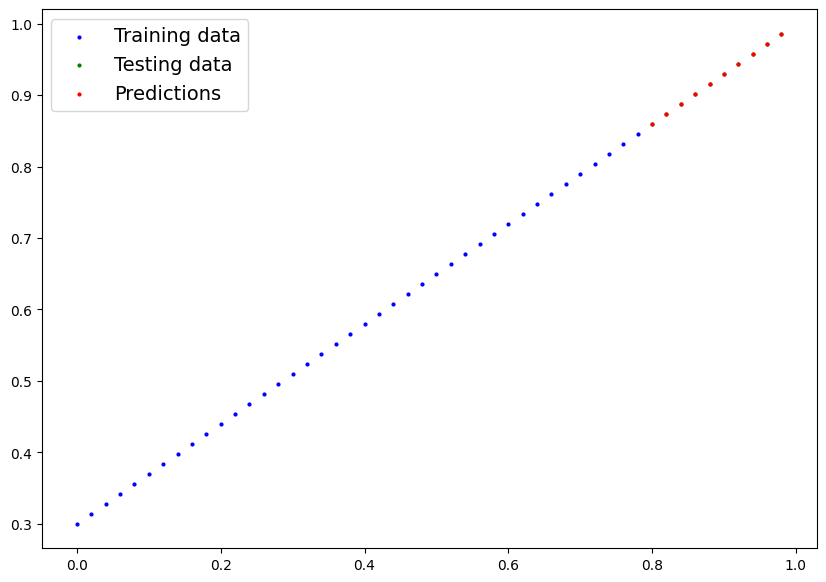

In [54]:
plot_predictions(predictions=y_preds)

In [55]:
# Save model
from pathlib import Path
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)
model_name = '01_pytorch_workflow_model_1.pth'
model_save_path = model_path / model_name
print(f'Saving model to: {model_save_path}')
torch.save(obj=model_1.state_dict(), f=model_save_path)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [56]:
# Load model
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(model_save_path))
loaded_model_1.to(device)
print(f'Loaded model:\n{loaded_model_1}')
print(f'Model on device:\n{next(loaded_model_1.parameters()).device}')

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cpu


In [57]:
# Evaluate the loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])